In [38]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
import time
from IPython import display
IMG_PATH = 'H:/3710_GAN/tensorflow_datasets'
RETRAIN = True

In [39]:
train = tfds.load('celeb_a', split='train', data_dir=IMG_PATH, download=False)
test = tfds.load('celeb_a', split='test', data_dir=IMG_PATH, download=False)
validation = tfds.load('celeb_a', split='validation', data_dir=IMG_PATH, download=False)

In [40]:
ds = train.concatenate(test).concatenate(validation)
len(ds)

202599

In [41]:
BATCH_SIZE = 64
ds = ds.batch(BATCH_SIZE)

In [42]:
# resize image
def transform_images(row, size):
    x_train = tf.image.resize(row['image'], size)
    x_train = x_train  / 255.0
    return x_train

ds = ds.map(lambda row:transform_images(row, (192, 160)))
ds

<MapDataset shapes: (None, 192, 160, 3), types: tf.float32>

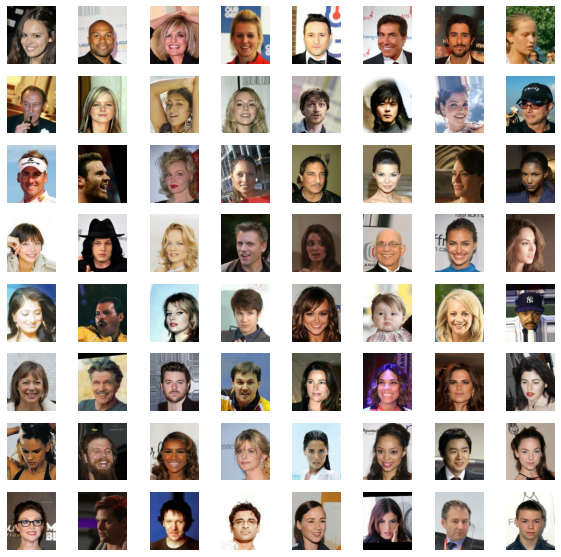

In [43]:
plt.figure(1, figsize=(10,10))

for example in ds:
    for i in range(64):
        plt.subplot(8,8,i+1)    # the number of images in the grid is 5*5 (25)
        plt.imshow(example[i])
        plt.axis("off")
    plt.show()
    break


In [44]:
GEN_NOISE_SHAPE = (6, 5, 8)
GEN_RELU_ALPHA = 0.2

mean_loss_gen = Mean()
opt_gen = tf.keras.optimizers.Adam(learning_rate=4e-6)
gen_weight_init = tf.keras.initializers.TruncatedNormal(
    mean=0.0, stddev=0.02, seed=None
)

gen = tf.keras.models.Sequential()
gen.add(layers.Flatten(input_shape=GEN_NOISE_SHAPE))
gen.add(layers.Dense(6 * 5 * 512, use_bias = False, kernel_initializer=gen_weight_init, 
                activation = LeakyReLU(GEN_RELU_ALPHA)))
gen.add(layers.Reshape((6, 5, 512)))
gen.add(layers.SpatialDropout2D(0.2))
gen.add(layers.Conv2DTranspose(512, (3, 3), padding='same', activation=LeakyReLU(GEN_RELU_ALPHA),
                              use_bias = False, kernel_initializer=gen_weight_init))
gen.add(layers.Conv2DTranspose(256, (3, 3), padding = 'same', strides = (2, 2), use_bias = False,
                               kernel_initializer=gen_weight_init) )
gen.add(layers.BatchNormalization())
gen.add(LeakyReLU(GEN_RELU_ALPHA))
gen.add(layers.Conv2DTranspose(128, (4, 4), padding ='same', activation=LeakyReLU(GEN_RELU_ALPHA), use_bias = False, 
                               kernel_initializer = gen_weight_init))
gen.add(layers.Conv2DTranspose(64, (4, 4), padding ='same', strides = (2, 2),
                                    use_bias = False, 
                                    kernel_initializer = gen_weight_init))
gen.add(layers.BatchNormalization())
gen.add(LeakyReLU(GEN_RELU_ALPHA))
gen.add(layers.SpatialDropout2D(0.2))

gen.add(layers.Conv2DTranspose(16, (5,5), padding ='same', strides = (2, 2),
                                     use_bias = False, 
                                    kernel_initializer = gen_weight_init))
gen.add(layers.BatchNormalization())
gen.add(LeakyReLU(GEN_RELU_ALPHA))
gen.add(layers.SpatialDropout2D(0.15))
gen.add(layers.Conv2DTranspose(8, (6,6), padding ='same', strides = (2, 2),
                                     use_bias = False, 
                                    kernel_initializer = gen_weight_init))
gen.add(layers.BatchNormalization())
gen.add(LeakyReLU(GEN_RELU_ALPHA))
gen.add(layers.SpatialDropout2D(0.15))

gen.add(layers.Conv2DTranspose(8, (7,7), padding ='same', strides = (2, 2),
                                     activation=LeakyReLU(GEN_RELU_ALPHA), use_bias = False, 
                                    kernel_initializer = gen_weight_init))

gen.add(layers.Conv2DTranspose(3, (5,5), padding ='same',
                                     activation='tanh', use_bias = False, 
                                    kernel_initializer = gen_weight_init))
# gen.summary()

In [45]:
DISC_ALPHA = 0.3
IMAGE_SIZE = (192,160,3)

mean_loss_dis = Mean()
opt_dis = tf.keras.optimizers.Adam(learning_rate=1e-6)
dis_weight_init = tf.keras.initializers.TruncatedNormal(
    mean=0.0, stddev=0.02, seed=None
)
input = layers.Input(shape = IMAGE_SIZE)
    
conv_1 = layers.Conv2D(32, (4, 4), activation=LeakyReLU(DISC_ALPHA), padding = 'same')(input)
max_pool_1 = layers.MaxPool2D(2)(conv_1)
conv_2 = layers.Conv2D(64, (4, 4), activation=LeakyReLU(DISC_ALPHA), padding = 'same')(max_pool_1)
max_pool_2 = layers.MaxPool2D(2)(conv_2)
global_pool_1 = layers.GlobalAveragePooling2D()(max_pool_2)

sp_dropout_1 = layers.SpatialDropout2D(0.2)(max_pool_2)
conv_3 = layers.Conv2D(128, (3, 3), activation=LeakyReLU(DISC_ALPHA), padding = 'same')(sp_dropout_1)
max_pool_3 = layers.MaxPool2D(2)(conv_3)
conv_4 = layers.Conv2D(256, (3, 3), activation=LeakyReLU(DISC_ALPHA), padding = 'same')(max_pool_3)
max_pool_4 = layers.MaxPool2D(2)(conv_4)
global_pool_2 = layers.GlobalAveragePooling2D()(max_pool_4)

sp_dropout_2 = layers.SpatialDropout2D(0.2)(max_pool_4)
conv_5 = layers.Conv2D(512, (2, 2), activation=LeakyReLU(DISC_ALPHA), padding = 'same')(sp_dropout_2)
max_pool_5 = layers.MaxPool2D(2)(conv_5)
global_pool_3 = layers.GlobalAveragePooling2D()(max_pool_5)

concat = layers.Concatenate()([global_pool_1, global_pool_2, global_pool_3])
dropout = layers.Dropout(0.2)(concat)
dense_1 = layers.Dense(32, activation=LeakyReLU(DISC_ALPHA))(dropout)
dense_2 = layers.Dense(1)(dense_1)

dis = Model(inputs=input, outputs = dense_2)
# dis.summary()

In [46]:
NOISE_SHAPE = (6,5,8)
PRED_COUNT = 9

tf.random.set_seed(42)
seed_noise = tf.random.normal([PRED_COUNT,*(NOISE_SHAPE)], seed = 42)

# fig, axes = plt.subplots(nrows = PRED_COUNT, ncols = NOISE_SHAPE[2], figsize = (10, 14))

# for i in range(9):
#     for j in range(NOISE_SHAPE[2]):
#         axes[i][j].imshow(seed_noise[i, :, :, j], cmap = 'gray')
#         axes[i][j].axis(False)
#         axes[i][j].grid(False)
#         axes[i][j].set_title(f"Img {i + 1}, Ch {j + 1}")
        
# plt.suptitle(f'Input Seed data. Shape: {seed_noise.shape}', fontsize = 20)
# plt.tight_layout()

In [47]:
checkpoint_dir = 'H:/3710_GAN/ckpt'

checkpoint = tf.train.Checkpoint(
    start_epoch=tf.Variable(1),
    opt_gen=opt_gen,
    opt_dis=opt_dis,
    gen=gen,
    dis=dis)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5)

START_EPOCH = 1
if RETRAIN:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    START_EPOCH = checkpoint.start_epoch.numpy()

print("Starting training from Epoch", START_EPOCH)

Starting training from Epoch 124


In [48]:
def generate_images(seed):
    pred = gen(seed, training = False)

    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (9, 11))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow((pred[i] * 0.5) + 0.5)
        ax.axis(False)
        ax.grid(False)

    plt.suptitle('Generator Predictions', fontsize = 20)
    
    plt.tight_layout()


In [49]:
# dis(gen(seed_noise, training = False), training = False).numpy()

In [50]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
DISC_LABEL_SMOOTHING = 0.25
def discriminator_loss(real_output, fake_output):
    pos_labels = tf.ones_like(real_output) - (tf.random.uniform(real_output.shape) * DISC_LABEL_SMOOTHING)
    neg_labels = tf.zeros_like(fake_output) + (tf.random.uniform(fake_output.shape) * DISC_LABEL_SMOOTHING)
    real_loss = cross_entropy(pos_labels, real_output)
    fake_loss = cross_entropy(neg_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [51]:
# @tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, *GEN_NOISE_SHAPE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen(noise, training = True)

        real_output = dis(images, training = True)
        fake_output = dis(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    mean_loss_gen(gen_loss)
    mean_loss_dis(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis.trainable_variables)

    opt_gen.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    opt_dis.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))

In [52]:
gen_losses = []
disc_losses = []

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        mean_loss_gen.reset_states()
        mean_loss_dis.reset_states()
        
        print(f"\nTraining Epoch {epoch + START_EPOCH}\n")
        
        for (idx, image_batch) in enumerate(ds):
            train_step(image_batch)

            if (idx + 1) % 10 == 0:
                print(". ", end = '')
            if (idx + 1) % 250 == 0:
                print(idx + 1)
        
        checkpoint.start_epoch.assign_add(1)

        display.clear_output(wait = True)
        
#         generate_images(seed_noise)

        
        ckpt_manager.save()
            
        gen_losses.append(mean_loss_gen.result())
        disc_losses.append(mean_loss_dis.result())

        print("Epoch:", epoch+START_EPOCH)
        print('Generator Loss:', mean_loss_gen.result())
        print('Discriminator Loss:', mean_loss_dis.result())
        print('Time elapsed (secs):', time.time() - start)

    display.clear_output(wait = True)

In [53]:
EPOCHS = 50 
train(ds, epochs=EPOCHS)

print(f'Final Generator Loss: {mean_loss_gen.result()}')
print(f'Final Discriminator Loss: {mean_loss_dis.result()}')

Final Generator Loss: 0.6965542435646057
Final Discriminator Loss: 1.3850022554397583


In [54]:
gen.save("H:/3710_GAN/generator")
dis.save("H:/3710_GAN/discriminator")

INFO:tensorflow:Assets written to: H:/3710_GAN/generator\assets


INFO:tensorflow:Assets written to: H:/3710_GAN/generator\assets


INFO:tensorflow:Assets written to: H:/3710_GAN/discriminator\assets


INFO:tensorflow:Assets written to: H:/3710_GAN/discriminator\assets


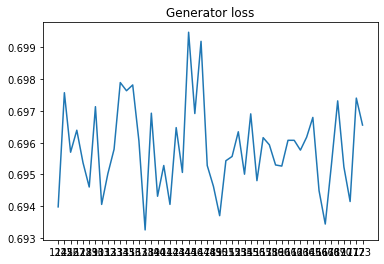

In [55]:
epoch_range = range(START_EPOCH, EPOCHS + START_EPOCH)

plt.plot(epoch_range, gen_losses)
plt.xticks(epoch_range)
plt.title('Generator loss')
plt.show()

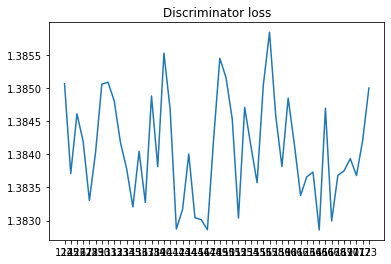

In [56]:
plt.plot(epoch_range, disc_losses)
plt.xticks(epoch_range)
plt.title('Discriminator loss')
plt.show()

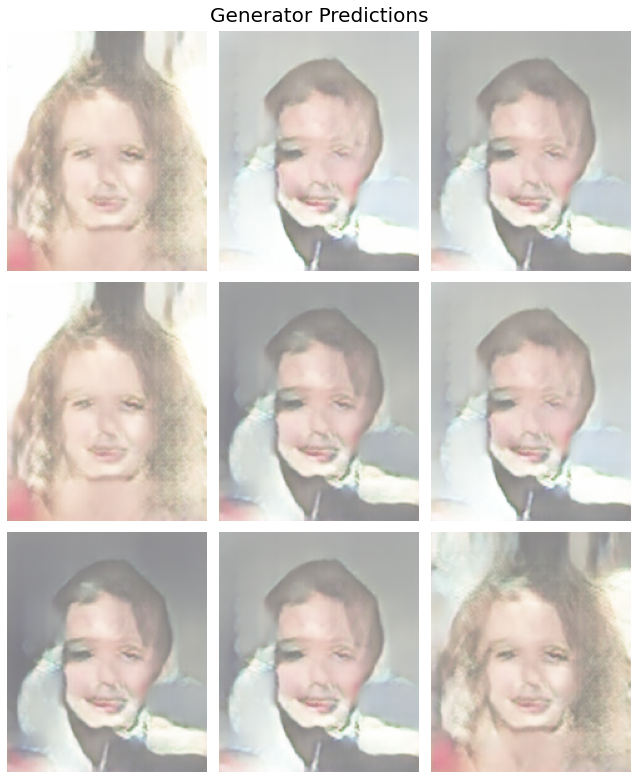

In [57]:
generate_images(seed_noise)